In [1]:
import glob
import json

import numpy as np
from matplotlib import pyplot as plt

## All benchmarks, all hyperparameters are learned

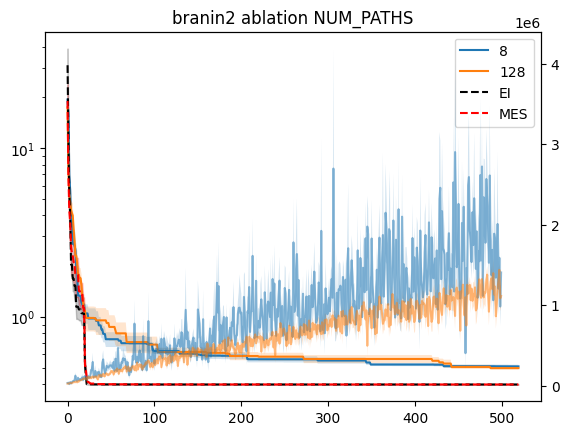

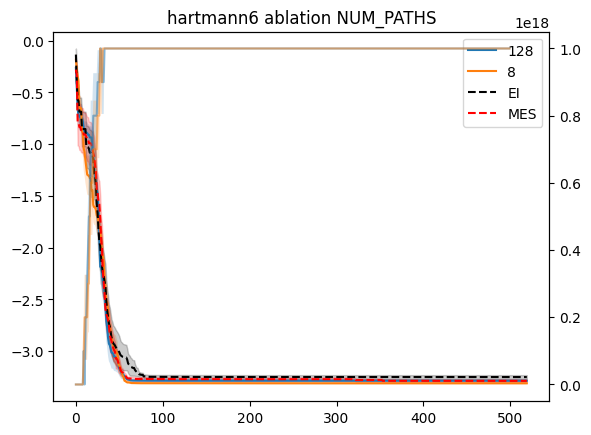

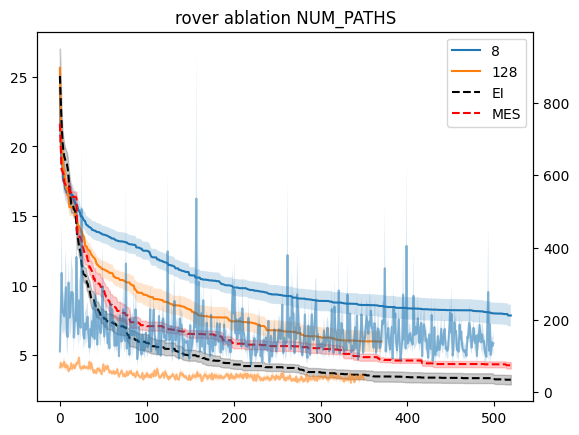

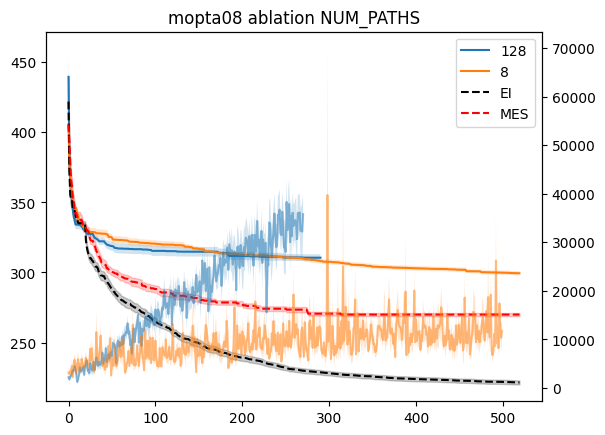

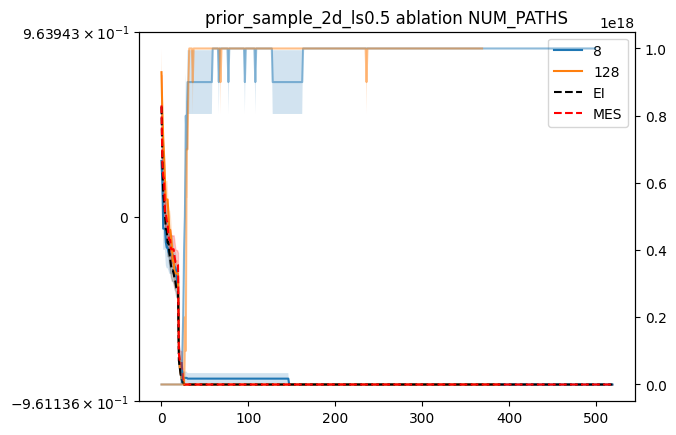

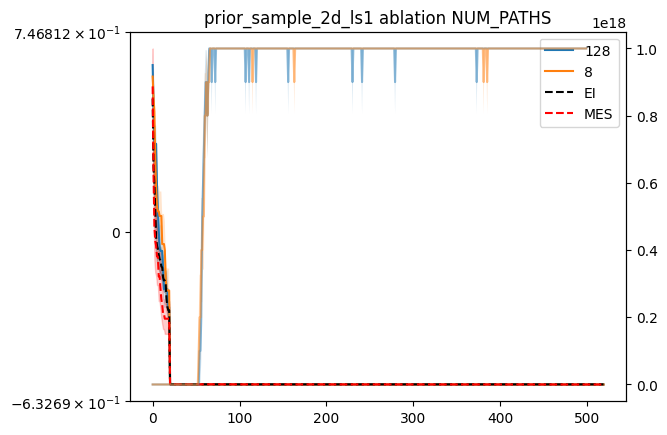

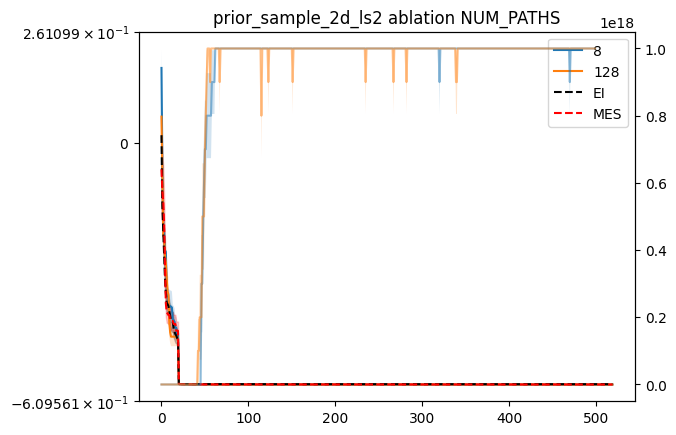

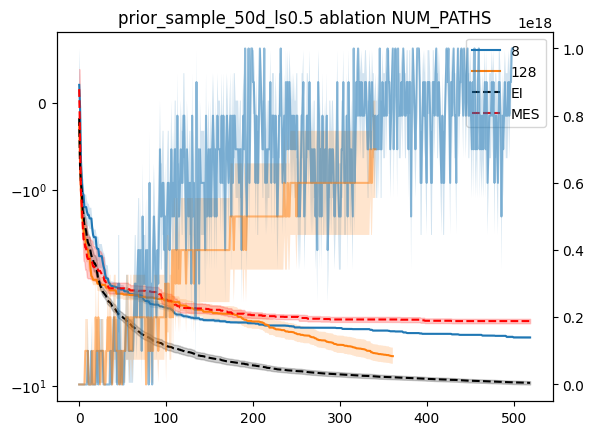

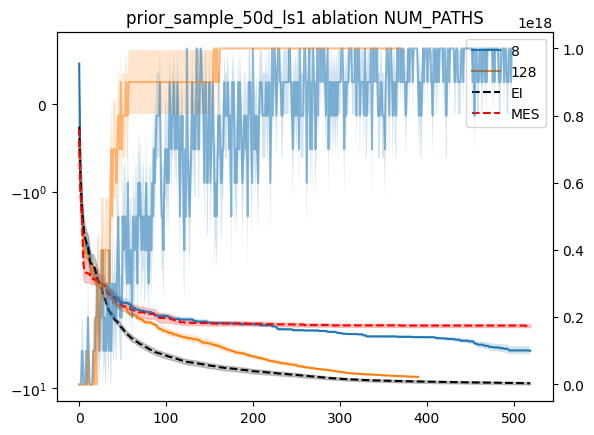

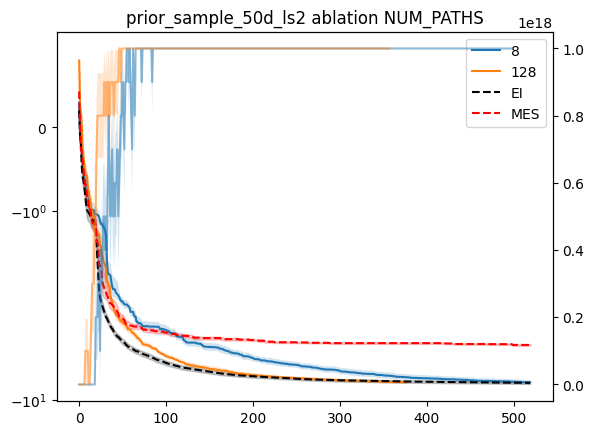

In [30]:
benchmarks = ['branin2','hartmann6', 'rover', 'mopta08', 'prior_sample_2d_ls0.5', 'prior_sample_2d_ls1', 'prior_sample_2d_ls2','prior_sample_50d_ls0.5', 'prior_sample_50d_ls1', 'prior_sample_50d_ls2']

run_dirs = glob.glob('results/ves_gamma_vs_ei2/*')

for benchmark in benchmarks:
    
    def general_dir_match(
            args: dict,
    ):
        if not 'prior_sample' in benchmark:
            return True
        else:
            ls = float(benchmark.split('_')[-1][2:])
            set_ls = args['set_lengthscale'] 
            return set_ls is None# and float(ls) == float(set_ls)
    
    relevant_dirs = [d for d in run_dirs if json.load(open(f'{d}/args.json'))['benchmark'] == benchmark]
    

    def def_dir_match(
            args: dict
    ):
        return args['clamp_min'] == 1e-10 \
            and args['sample_around_best'] == True \
            and args['acqf_raw_samples'] == 512 \
            and args['num_paths'] == 64 \
            and args['num_iter'] == 50


    ei_dirs = [d for d in relevant_dirs if f'{d}/train_x_ei.npy' in glob.glob(f'{d}/*')]
    mes_dirs = [d for d in relevant_dirs if f'{d}/train_x_mes.npy' in glob.glob(f'{d}/*')]
    # remove ei_dirs from relevant_dirs
    relevant_dirs = [d for d in relevant_dirs if d not in ei_dirs]
    relevant_dirs = [d for d in relevant_dirs if general_dir_match(json.load(open(f'{d}/args.json')))]
    
    default_dirs = [d for d in relevant_dirs if def_dir_match(json.load(open(f'{d}/args.json'))) and 'train_y_ves.npy' in d]
    
    # ablation NUM_PATHS
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    num_paths = [8, 128]
    ablation_dirs = [d for d in relevant_dirs if
                     json.load(open(f'{d}/args.json'))['num_paths'] in num_paths] + default_dirs
    ablation_hashes = list(set([int(d.split('/')[-1].split('_')[1]) for d in ablation_dirs]))
    
    for h in ablation_hashes:
        dirs = [d for d in ablation_dirs if int(d.split('/')[-1].split('_')[1]) == h]
        ves_y = [np.maximum.accumulate(np.load(f'{d}/train_y_ves.npy')) for d in dirs]
        
        if len(ves_y) == 0:
            continue
        min_len = min([len(y) for y in ves_y])
        ves_y = [y[:min_len] for y in ves_y]
        ves_y = -np.stack(ves_y).squeeze(-1)
        ves_y_mean = ves_y.mean(axis=0)
        ves_y_std = ves_y.std(axis=0)/ np.sqrt(len(ves_y))

        ves_k = [np.load(f'{d}/k_vals.npy') for d in dirs]
        min_len = min([len(k) for k in ves_k])
        ves_k = [k[:min_len] for k in ves_k]
        ves_k = np.stack(ves_k)
        ves_k_mean = ves_k.mean(axis=0)
        ves_k_std = ves_k.std(axis=0)/ np.sqrt(len(ves_k))
        ax2.plot(ves_k_mean, label=f'{json.load(open(f"{dirs[0]}/args.json"))["num_paths"]}', alpha=0.5)
        ax2.fill_between(np.arange(len(ves_k_mean)), ves_k_mean-ves_k_std, ves_k_mean+ves_k_std, alpha=0.2)
        
        ax.plot(ves_y_mean, label=f'{json.load(open(f"{dirs[0]}/args.json"))["num_paths"]}')
        ax.fill_between(np.arange(len(ves_y_mean)), ves_y_mean-ves_y_std, ves_y_mean+ves_y_std, alpha=0.2)
        
    ei_y = [np.maximum.accumulate(np.load(f'{d}/train_y_ei.npy')) for d in ei_dirs]
    min_len = min([len(y) for y in ei_y])
    ei_y = [y[:min_len] for y in ei_y]
    ei_y = -np.stack(ei_y).squeeze(-1)
    ei_y_mean = ei_y.mean(axis=0)
    ei_y_std = ei_y.std(axis=0)/ np.sqrt(len(ei_y))
    
    mes_y = [np.maximum.accumulate(np.load(f'{d}/train_y_mes.npy')) for d in mes_dirs]
    min_len = min([len(y) for y in mes_y])
    mes_y = [y[:min_len] for y in mes_y]
    mes_y = -np.stack(mes_y).squeeze(-1)
    mes_y_mean = mes_y.mean(axis=0)
    mes_y_std = mes_y.std(axis=0)/ np.sqrt(len(mes_y))
    
    ax.plot(ei_y_mean, label='EI', color='black', linestyle='--')
    ax.fill_between(np.arange(len(ei_y_mean)), ei_y_mean-ei_y_std, ei_y_mean+ei_y_std, alpha=0.2, color='black')
    
    ax.plot(mes_y_mean, label='MES', color='red', linestyle='--')
    ax.fill_between(np.arange(len(mes_y_mean)), mes_y_mean-mes_y_std, mes_y_mean+mes_y_std, alpha=0.2, color='red')
    
    ax.legend()
    ax.set_title(f'{benchmark} ablation NUM_PATHS')
    if benchmark == 'branin2':
        ax.set_yscale('log')
    if benchmark.startswith('prior_sample'):
        # find best value
        ax.set_yscale('symlog')
    plt.show()
    
    

## Prior sample benchmarks, hyperparameters are set to the correct value

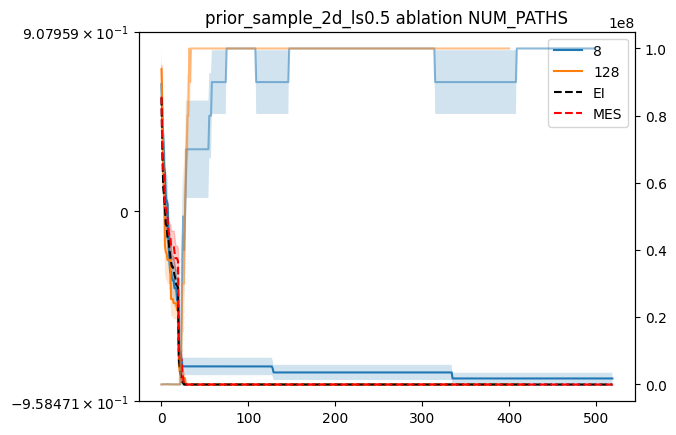

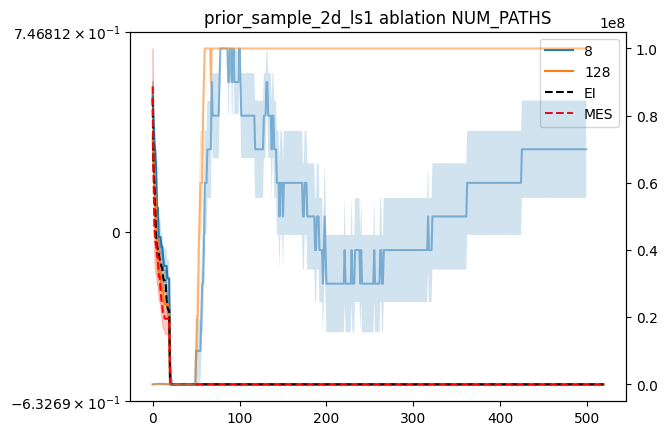

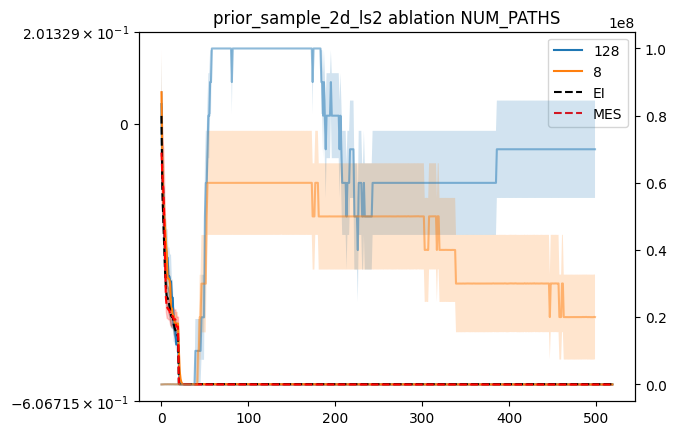

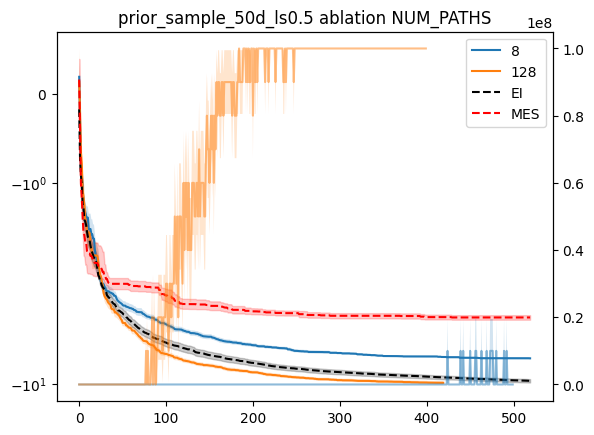

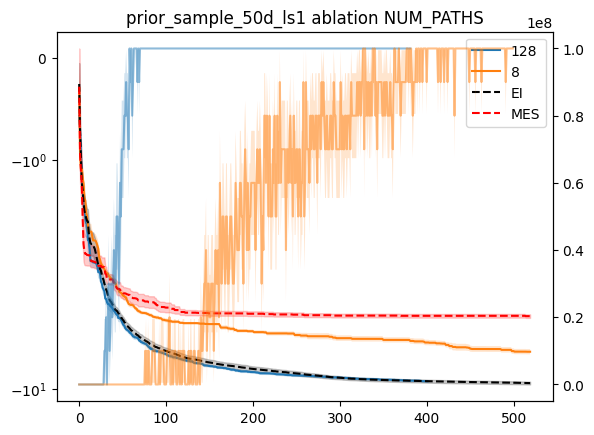

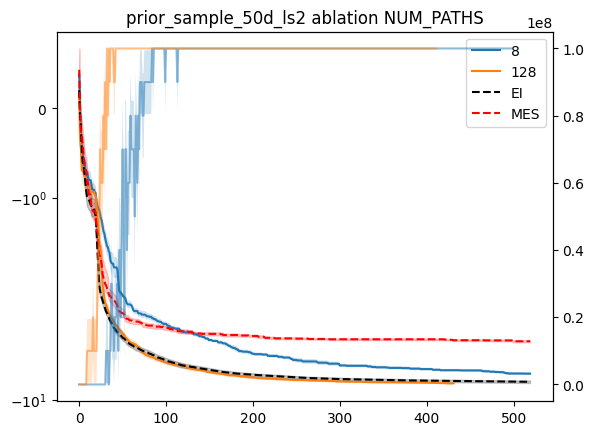

In [31]:
benchmarks = ['prior_sample_2d_ls0.5', 'prior_sample_2d_ls1', 'prior_sample_2d_ls2','prior_sample_50d_ls0.5', 'prior_sample_50d_ls1', 'prior_sample_50d_ls2']

run_dirs = glob.glob('results/ves_gamma_vs_ei2/*')

for benchmark in benchmarks:

    def general_dir_match(
            args: dict,
    ):
        if not 'prior_sample' in benchmark:
            return True
        else:
            ls = float(benchmark.split('_')[-1][2:])
            set_ls = args['set_lengthscale']
            return set_ls is not None and set_ls == ls

    relevant_dirs = [d for d in run_dirs if json.load(open(f'{d}/args.json'))['benchmark'] == benchmark]


    def def_dir_match(
            args: dict
    ):
        return args['clamp_min'] == 1e-10 \
            and args['sample_around_best'] == True \
            and args['acqf_raw_samples'] == 512 \
            and args['num_paths'] == 64 \
            and args['num_iter'] == 50


    ei_dirs = [d for d in relevant_dirs if f'{d}/train_x_ei.npy' in glob.glob(f'{d}/*')]
    mes_dirs = [d for d in relevant_dirs if f'{d}/train_x_mes.npy' in glob.glob(f'{d}/*')]
    # remove ei_dirs from relevant_dirs
    relevant_dirs = [d for d in relevant_dirs if d not in ei_dirs]
    relevant_dirs = [d for d in relevant_dirs if general_dir_match(json.load(open(f'{d}/args.json')))]

    default_dirs = [d for d in relevant_dirs if def_dir_match(json.load(open(f'{d}/args.json'))) and 'train_y_ves.npy' in d]

    # ablation NUM_PATHS
    fig, ax = plt.subplots()
    ax2= ax.twinx()
    num_paths = [8, 128]
    ablation_dirs = [d for d in relevant_dirs if
                     json.load(open(f'{d}/args.json'))['num_paths'] in num_paths] + default_dirs
    ablation_hashes = list(set([int(d.split('/')[-1].split('_')[1]) for d in ablation_dirs]))

    for h in ablation_hashes:
        dirs = [d for d in ablation_dirs if int(d.split('/')[-1].split('_')[1]) == h]
        ves_y = [np.maximum.accumulate(np.load(f'{d}/train_y_ves.npy')) for d in dirs]
        if len(ves_y) == 0:
            continue
        min_len = min([len(y) for y in ves_y])
        ves_y = [y[:min_len] for y in ves_y]
        ves_y = -np.stack(ves_y).squeeze(-1)
        ves_y_mean = ves_y.mean(axis=0)
        ves_y_std = ves_y.std(axis=0)/ np.sqrt(len(ves_y))
        ax.plot(ves_y_mean, label=f'{json.load(open(f"{dirs[0]}/args.json"))["num_paths"]}')
        ax.fill_between(np.arange(len(ves_y_mean)), ves_y_mean-ves_y_std, ves_y_mean+ves_y_std, alpha=0.2)

        ves_k = [np.load(f'{d}/k_vals.npy') for d in dirs]
        min_len = min([len(k) for k in ves_k])
        ves_k = [k[:min_len] for k in ves_k]
        ves_k = np.stack(ves_k)
        ves_k_mean = ves_k.mean(axis=0)
        ves_k_std = ves_k.std(axis=0)/ np.sqrt(len(ves_k))
        ax2.plot(ves_k_mean, label=f'{json.load(open(f"{dirs[0]}/args.json"))["num_paths"]}', alpha=0.5)
        ax2.fill_between(np.arange(len(ves_k_mean)), ves_k_mean-ves_k_std, ves_k_mean+ves_k_std, alpha=0.2)
    ei_y = [np.maximum.accumulate(np.load(f'{d}/train_y_ei.npy')) for d in ei_dirs]
    min_len = min([len(y) for y in ei_y])
    ei_y = [y[:min_len] for y in ei_y]
    ei_y = -np.stack(ei_y).squeeze(-1)
    ei_y_mean = ei_y.mean(axis=0)
    ei_y_std = ei_y.std(axis=0)/ np.sqrt(len(ei_y))

    mes_y = [np.maximum.accumulate(np.load(f'{d}/train_y_mes.npy')) for d in mes_dirs]
    min_len = min([len(y) for y in mes_y])
    mes_y = [y[:min_len] for y in mes_y]
    mes_y = -np.stack(mes_y).squeeze(-1)
    mes_y_mean = mes_y.mean(axis=0)
    mes_y_std = mes_y.std(axis=0)/ np.sqrt(len(mes_y))

    ax.plot(ei_y_mean, label='EI', color='black', linestyle='--')
    ax.fill_between(np.arange(len(ei_y_mean)), ei_y_mean-ei_y_std, ei_y_mean+ei_y_std, alpha=0.2, color='black')
    
    ax.plot(mes_y_mean, label='MES', color='red', linestyle='--')
    ax.fill_between(np.arange(len(mes_y_mean)), mes_y_mean-mes_y_std, mes_y_mean+mes_y_std, alpha=0.2, color='red')
    
    ax.legend()
    ax.set_title(f'{benchmark} ablation NUM_PATHS')
    if benchmark == 'branin2':
        ax.set_yscale('log')
    if benchmark.startswith('prior_sample'):
        # find best value
        ax.set_yscale('symlog')
    plt.show()
    
    

## Prior sample benchmarks, hyperparameters are set to two times the correct value

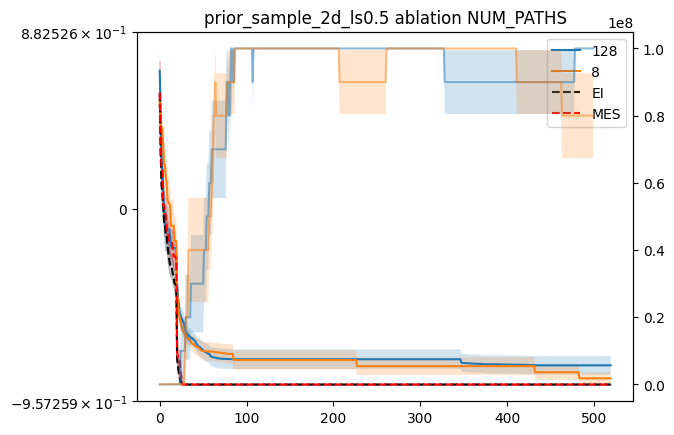

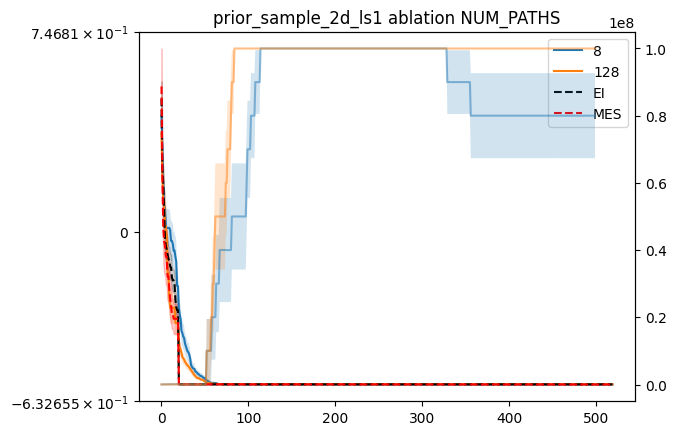

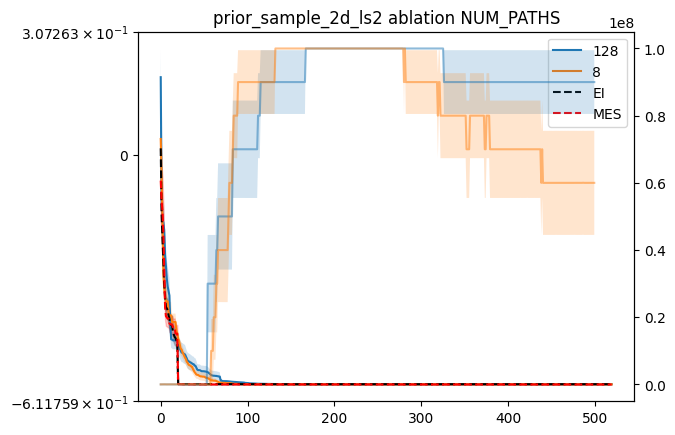

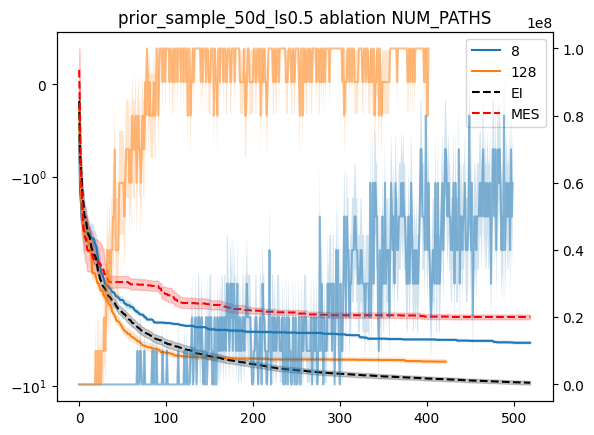

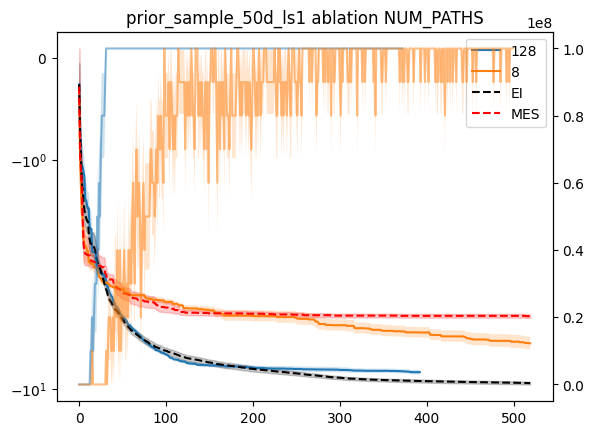

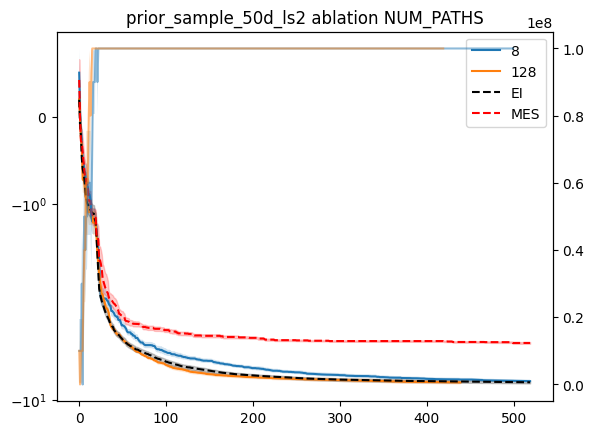

In [32]:
benchmarks = ['prior_sample_2d_ls0.5', 'prior_sample_2d_ls1', 'prior_sample_2d_ls2','prior_sample_50d_ls0.5', 'prior_sample_50d_ls1', 'prior_sample_50d_ls2']

run_dirs = glob.glob('results/ves_gamma_vs_ei2/*')

for benchmark in benchmarks:

    def general_dir_match(
            args: dict,
    ):
        if not 'prior_sample' in benchmark:
            return True
        else:
            ls = float(benchmark.split('_')[-1][2:])
            set_ls = args['set_lengthscale']
            return set_ls is not None and set_ls != ls

    relevant_dirs = [d for d in run_dirs if json.load(open(f'{d}/args.json'))['benchmark'] == benchmark]


    def def_dir_match(
            args: dict
    ):
        return args['clamp_min'] == 1e-10 \
            and args['sample_around_best'] == True \
            and args['acqf_raw_samples'] == 512 \
            and args['num_paths'] == 64 \
            and args['num_iter'] == 50


    ei_dirs = [d for d in relevant_dirs if f'{d}/train_x_ei.npy' in glob.glob(f'{d}/*')]
    mes_dirs = [d for d in relevant_dirs if f'{d}/train_x_mes.npy' in glob.glob(f'{d}/*')]
    # remove ei_dirs from relevant_dirs
    relevant_dirs = [d for d in relevant_dirs if d not in ei_dirs]
    relevant_dirs = [d for d in relevant_dirs if general_dir_match(json.load(open(f'{d}/args.json')))]

    default_dirs = [d for d in relevant_dirs if def_dir_match(json.load(open(f'{d}/args.json'))) and 'train_y_ves.npy' in d]

    # ablation NUM_PATHS
    fig, ax = plt.subplots()
    ax2= ax.twinx()
    num_paths = [8, 128]
    ablation_dirs = [d for d in relevant_dirs if
                     json.load(open(f'{d}/args.json'))['num_paths'] in num_paths] + default_dirs
    ablation_hashes = list(set([int(d.split('/')[-1].split('_')[1]) for d in ablation_dirs]))

    for h in ablation_hashes:
        dirs = [d for d in ablation_dirs if int(d.split('/')[-1].split('_')[1]) == h]
        ves_y = [np.maximum.accumulate(np.load(f'{d}/train_y_ves.npy')) for d in dirs]
        if len(ves_y) == 0:
            continue
        min_len = min([len(y) for y in ves_y])
        ves_y = [y[:min_len] for y in ves_y]
        ves_y = -np.stack(ves_y).squeeze(-1)
        ves_y_mean = ves_y.mean(axis=0)
        ves_y_std = ves_y.std(axis=0)/ np.sqrt(len(ves_y))
        ax.plot(ves_y_mean, label=f'{json.load(open(f"{dirs[0]}/args.json"))["num_paths"]}')
        ax.fill_between(np.arange(len(ves_y_mean)), ves_y_mean-ves_y_std, ves_y_mean+ves_y_std, alpha=0.2)

        ves_k = [np.load(f'{d}/k_vals.npy') for d in dirs]
        min_len = min([len(k) for k in ves_k])
        ves_k = [k[:min_len] for k in ves_k]
        ves_k = np.stack(ves_k)
        ves_k_mean = ves_k.mean(axis=0)
        ves_k_std = ves_k.std(axis=0)/ np.sqrt(len(ves_k))
        ax2.plot(ves_k_mean, label=f'{json.load(open(f"{dirs[0]}/args.json"))["num_paths"]}', alpha=0.5)
        ax2.fill_between(np.arange(len(ves_k_mean)), ves_k_mean-ves_k_std, ves_k_mean+ves_k_std, alpha=0.2)
    ei_y = [np.maximum.accumulate(np.load(f'{d}/train_y_ei.npy')) for d in ei_dirs]
    min_len = min([len(y) for y in ei_y])
    ei_y = [y[:min_len] for y in ei_y]
    ei_y = -np.stack(ei_y).squeeze(-1)
    ei_y_mean = ei_y.mean(axis=0)
    ei_y_std = ei_y.std(axis=0)/ np.sqrt(len(ei_y))

    mes_y = [np.maximum.accumulate(np.load(f'{d}/train_y_mes.npy')) for d in mes_dirs]
    min_len = min([len(y) for y in mes_y])
    mes_y = [y[:min_len] for y in mes_y]
    mes_y = -np.stack(mes_y).squeeze(-1)
    mes_y_mean = mes_y.mean(axis=0)
    mes_y_std = mes_y.std(axis=0)/ np.sqrt(len(mes_y))

    ax.plot(ei_y_mean, label='EI', color='black', linestyle='--')
    ax.fill_between(np.arange(len(ei_y_mean)), ei_y_mean-ei_y_std, ei_y_mean+ei_y_std, alpha=0.2, color='black')
    
    ax.plot(mes_y_mean, label='MES', color='red', linestyle='--')
    ax.fill_between(np.arange(len(mes_y_mean)), mes_y_mean-mes_y_std, mes_y_mean+mes_y_std, alpha=0.2, color='red')
    ax.legend()
    ax.set_title(f'{benchmark} ablation NUM_PATHS')
    if benchmark == 'branin2':
        ax.set_yscale('log')
    if benchmark.startswith('prior_sample'):
        # find best value
        ax.set_yscale('symlog')
    plt.show()
    
    

## Ablation num VES iterations


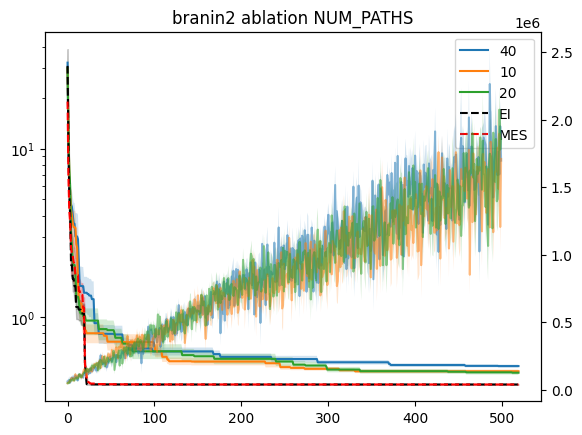

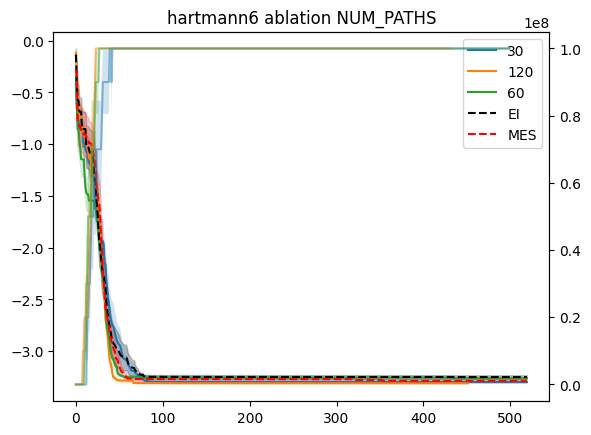

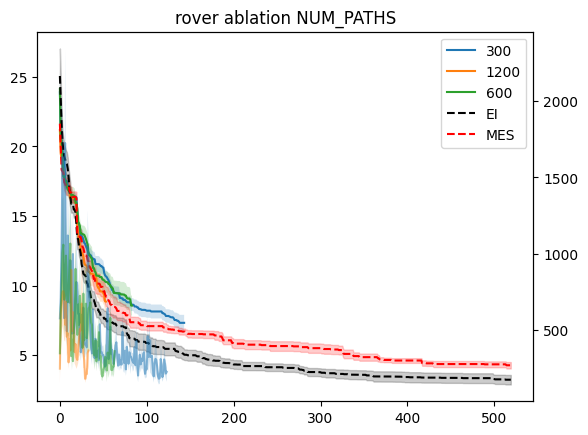

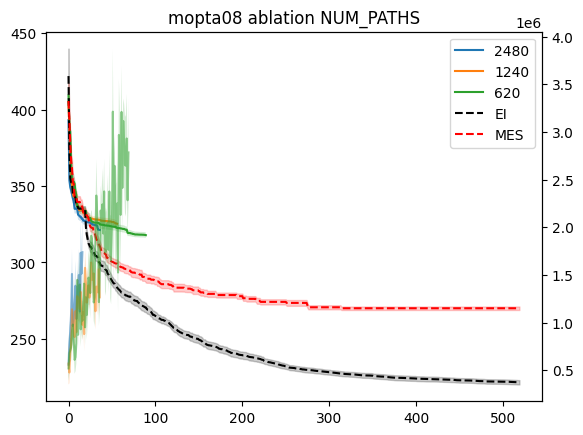

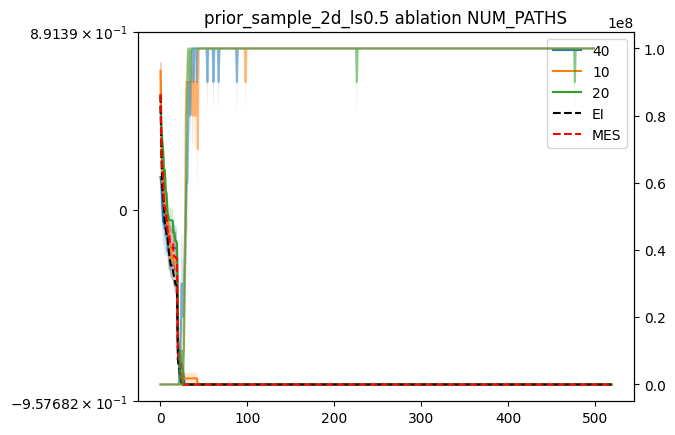

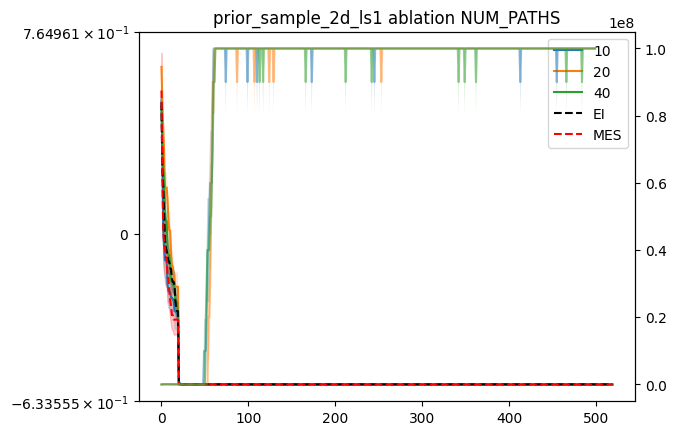

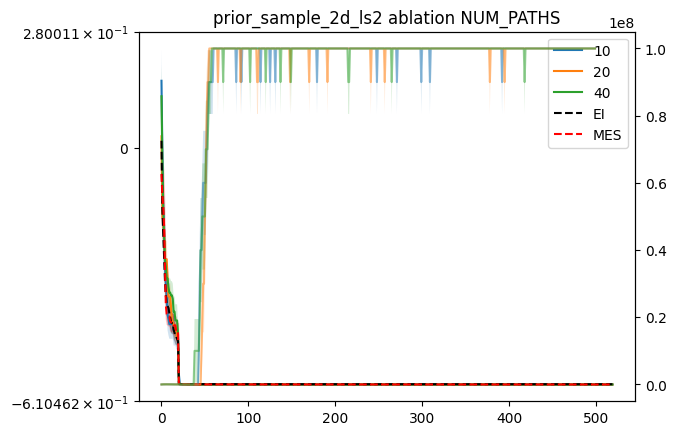

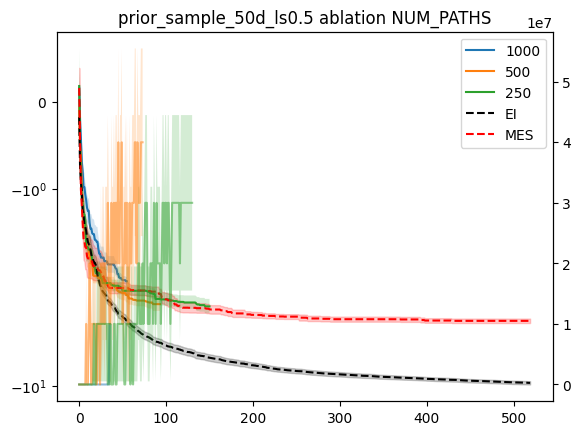

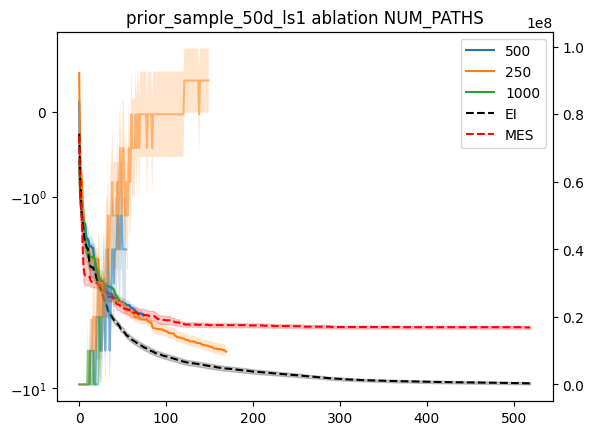

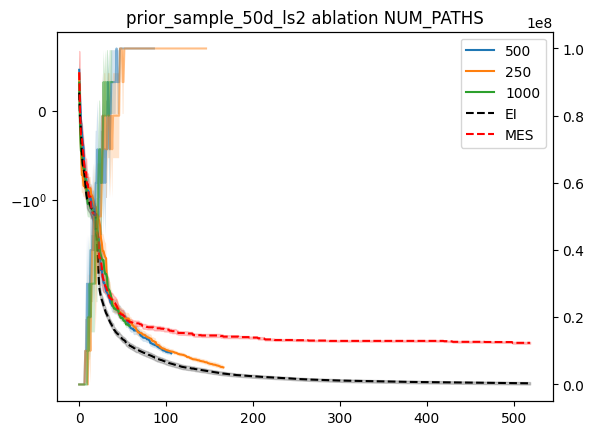

In [33]:
benchmarks = ['branin2','hartmann6', 'rover', 'mopta08', 'prior_sample_2d_ls0.5', 'prior_sample_2d_ls1', 'prior_sample_2d_ls2','prior_sample_50d_ls0.5', 'prior_sample_50d_ls1', 'prior_sample_50d_ls2']

run_dirs = glob.glob('results/ves_gamma_vs_ei2/*')

for benchmark in benchmarks:

    def general_dir_match(
            args: dict,
    ):
        if not 'prior_sample' in benchmark:
            return True
        else:
            ls = float(benchmark.split('_')[-1][2:])
            set_ls = args['set_lengthscale']
            return set_ls is None

    relevant_dirs = [d for d in run_dirs if json.load(open(f'{d}/args.json'))['benchmark'] == benchmark]


    def def_dir_match(
            args: dict
    ):
        return args['clamp_min'] == 1e-10 \
            and args['sample_around_best'] == True \
            and args['acqf_raw_samples'] == 512 \
            and args['num_paths'] == 64 \
            and args['num_iter'] == 50


    ei_dirs = [d for d in relevant_dirs if f'{d}/train_x_ei.npy' in glob.glob(f'{d}/*')]
    mes_dirs = [d for d in relevant_dirs if f'{d}/train_x_mes.npy' in glob.glob(f'{d}/*')]
    # remove ei_dirs from relevant_dirs
    relevant_dirs = [d for d in relevant_dirs if d not in ei_dirs]
    relevant_dirs = [d for d in relevant_dirs if general_dir_match(json.load(open(f'{d}/args.json')))]

    default_dirs = [d for d in relevant_dirs if def_dir_match(json.load(open(f'{d}/args.json'))) and 'train_y_ves.npy' in d]

    # ablation num_iter
    fig, ax = plt.subplots()
    ax2= ax.twinx()
    ablation_dirs = [d for d in relevant_dirs if
                     json.load(open(f'{d}/args.json'))['num_iter'] != 50] + default_dirs
    ablation_hashes = list(set([int(d.split('/')[-1].split('_')[1]) for d in ablation_dirs]))

    for h in ablation_hashes:
        dirs = [d for d in ablation_dirs if int(d.split('/')[-1].split('_')[1]) == h]
        ves_y = [np.maximum.accumulate(np.load(f'{d}/train_y_ves.npy')) for d in dirs]
        if len(ves_y) == 0:
            continue
        min_len = min([len(y) for y in ves_y])
        ves_y = [y[:min_len] for y in ves_y]
        ves_y = -np.stack(ves_y).squeeze(-1)
        ves_y_mean = ves_y.mean(axis=0)
        ves_y_std = ves_y.std(axis=0)/ np.sqrt(len(ves_y))
        ax.plot(ves_y_mean, label=f'{json.load(open(f"{dirs[0]}/args.json"))["num_iter"]}')
        ax.fill_between(np.arange(len(ves_y_mean)), ves_y_mean-ves_y_std, ves_y_mean+ves_y_std, alpha=0.2)

        ves_k = [np.load(f'{d}/k_vals.npy') for d in dirs]
        min_len = min([len(k) for k in ves_k])
        ves_k = [k[:min_len] for k in ves_k]
        ves_k = np.stack(ves_k)
        ves_k_mean = ves_k.mean(axis=0)
        ves_k_std = ves_k.std(axis=0)/ np.sqrt(len(ves_k))
        ax2.plot(ves_k_mean, label=f'{json.load(open(f"{dirs[0]}/args.json"))["num_paths"]}', alpha=0.5)
        ax2.fill_between(np.arange(len(ves_k_mean)), ves_k_mean-ves_k_std, ves_k_mean+ves_k_std, alpha=0.2)
    ei_y = [np.maximum.accumulate(np.load(f'{d}/train_y_ei.npy')) for d in ei_dirs]
    min_len = min([len(y) for y in ei_y])
    ei_y = [y[:min_len] for y in ei_y]
    ei_y = -np.stack(ei_y).squeeze(-1)
    ei_y_mean = ei_y.mean(axis=0)
    ei_y_std = ei_y.std(axis=0)/ np.sqrt(len(ei_y))

    mes_y = [np.maximum.accumulate(np.load(f'{d}/train_y_mes.npy')) for d in mes_dirs]
    min_len = min([len(y) for y in mes_y])
    mes_y = [y[:min_len] for y in mes_y]
    mes_y = -np.stack(mes_y).squeeze(-1)
    mes_y_mean = mes_y.mean(axis=0)
    mes_y_std = mes_y.std(axis=0)/ np.sqrt(len(mes_y))

    ax.plot(ei_y_mean, label='EI', color='black', linestyle='--')
    ax.fill_between(np.arange(len(ei_y_mean)), ei_y_mean-ei_y_std, ei_y_mean+ei_y_std, alpha=0.2, color='black')

    ax.plot(mes_y_mean, label='MES', color='red', linestyle='--')
    ax.fill_between(np.arange(len(mes_y_mean)), mes_y_mean-mes_y_std, mes_y_mean+mes_y_std, alpha=0.2, color='red')
    ax.legend()
    ax.set_title(f'{benchmark} ablation NUM_PATHS')
    if benchmark == 'branin2':
        ax.set_yscale('log')
    if benchmark.startswith('prior_sample'):
        # find best value
        ax.set_yscale('symlog')
    plt.show()
    
    